# Anlisis de puntos criticos VBOX

Se van analizar los puntos criticos encontrados con reglas deterministicas:
1. Velocidades mayor a 50 (avg_speed)
2. Ac lat 0.15 +- (avg_lateral_a)
3. Ac lon 0.1+- (avg_longitudinal_a)
4. Vver 3+- (avg_vertical_speed)
5. Sver*speed (Ondulaciones rápidas) 
6. avg_speed(>50) * avg_ratius_ot(<50) (Curva rapida)

Para hacer un analisis de los puntos criticos se va a definir dos flujos

1. KDE (Kernel Density Estimation):
    * Tendremos como resultado del analisis hexagonos con mayor probalidad de criticidad
2. HDBSCAN+KDE (Hierarchical Density-Based Spatial Clustering + Kernel Density Estimation)
    * Filtrado de ruido (Puntos criticos puntuales)
    * Zonas de criticidad 
    * Dentro de las zonas (que parte es critica)

# Packages

In [2]:
# Imports básicos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Para HDBSCAN
from sklearn.cluster import HDBSCAN

# Para KDE
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde  # Alternativa más simple

# Para análisis espacial
from scipy.spatial import ConvexHull
from scipy.spatial.distance import pdist, squareform

# Para visualización avanzada
import matplotlib.colors as colors
from matplotlib.patches import Ellipse

# Read data

In [3]:
df_original = pd.read_csv("../simplified_vbox_data.csv")
df_original

,refe,h3_cell,loading_status,n_points,centroid_lat,centroid_lng,avg_heading,avg_speed,avg_vertical_speed,avg_height,avg_longitudinal_a,avg_lateral_a,avg_ratius_ot,avg_vehicle_w,avg_tkph_f,avg_tkph_r,avg_slope_percent,transparency
0,341139VBOX,8c66034b04da1ff,Loaded,6,7.906381,-75.536625,183.52,21.30,0.00,122.32,-0.01,0.01,NaN,974.3,1151.0,1111.0,0.0000,0.0535
1,341139VBOX,8c66034b04da3ff,Loaded,5,7.906241,-75.536523,180.46,20.86,-0.32,121.84,0.00,-0.00,NaN,974.3,1170.8,1131.8,-0.0020,0.0436
2,341139VBOX,8c66034b04da9ff,Loaded,6,7.906529,-75.536553,185.23,21.92,0.23,122.18,0.00,-0.03,NaN,974.3,1151.0,1111.0,0.0000,0.0550
3,341139VBOX,8c66034b04de1ff,Loaded,5,7.906818,-75.536584,137.55,19.87,0.13,122.14,0.02,-0.15,NaN,974.3,1131.2,1090.2,0.0120,0.0416
4,341139VBOX,8c66034b04de3ff,Loaded,2,7.906678,-75.536481,170.50,21.48,0.11,123.24,0.02,-0.16,NaN,974.3,1052.0,1007.0,0.0100,0.0180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,341139VBOX,8c661c94dd965ff,Empty,3,7.925121,-75.575462,333.18,29.28,0.23,95.64,0.00,-0.04,NaN,68.3,549.0,450.0,0.0067,0.0367
3340,341139VBOX,8c661c94dd967ff,Empty,2,7.924981,-75.575360,242.80,31.95,-0.06,95.73,0.02,-0.01,NaN,68.3,549.0,450.0,0.0000,0.0266
3341,341139VBOX,8c661c94dd9a5ff,Empty,2,7.923705,-75.574788,326.90,30.30,1.33,89.14,-0.02,-0.08,NaN,68.3,549.0,450.0,0.0500,0.0253
3342,341139VBOX,8c661c94dd9a7ff,Empty,3,7.923565,-75.574686,315.60,31.95,1.34,88.21,-0.01,-0.05,NaN,68.3,549.0,450.0,0.0400,0.0400


## Puntos criticos

In [4]:
def extract_critical_coordinates_by_rules(df):
    """
    Extrae SOLO las coordenadas de eventos críticos por regla
    """
    
    print("=== EXTRAYENDO COORDENADAS DE EVENTOS CRÍTICOS ===\n")
    
    critical_coords = {}
    
    # REGLA 1: Velocidades > 50 km/h
    rule1_mask = df['avg_speed'] > 50
    coords1 = df[rule1_mask][['centroid_lat', 'centroid_lng']].dropna()
    critical_coords['velocidad_alta'] = {
        'coords': coords1.values,
        'description': 'Velocidades > 50 km/h',
        'count': len(coords1),
        'color': 'red'
    }
    
    # REGLA 2: Aceleración lateral > ±0.15g
    rule2_mask = np.abs(df['avg_lateral_a']) > 0.15
    coords2 = df[rule2_mask][['centroid_lat', 'centroid_lng']].dropna()
    critical_coords['aceleracion_lateral'] = {
        'coords': coords2.values,
        'description': 'Aceleración lateral > ±0.15g',
        'count': len(coords2),
        'color': 'orange'
    }
    
    # REGLA 3: Aceleración longitudinal > ±0.1g
    rule3_mask = np.abs(df['avg_longitudinal_a']) > 0.1
    coords3 = df[rule3_mask][['centroid_lat', 'centroid_lng']].dropna()
    critical_coords['aceleracion_longitudinal'] = {
        'coords': coords3.values,
        'description': 'Aceleración longitudinal > ±0.1g',
        'count': len(coords3),
        'color': 'blue'
    }
    
    # REGLA 4: Velocidad vertical > ±3 m/s
    rule4_mask = np.abs(df['avg_vertical_speed']) > 3
    coords4 = df[rule4_mask][['centroid_lat', 'centroid_lng']].dropna()
    critical_coords['velocidad_vertical'] = {
        'coords': coords4.values,
        'description': 'Velocidad vertical > ±3 m/s',
        'count': len(coords4),
        'color': 'green'
    }
    
    # REGLA 5: Ondulaciones rápidas (Sver × Speed)
    rule5_mask = (df['avg_speed'] > 50) & (df['avg_vertical_speed'] > 3)
    coords5 = df[rule5_mask][['centroid_lat', 'centroid_lng']].dropna()
    critical_coords['ondulaciones_rapidas'] = {
            'coords': coords5.values,
            'description': f'Ondulaciones rápidas (Sver×Speed)',
            'count': len(coords5),
            'color': 'purple'
    }
    
    # REGLA 6: Curvas rápidas (Speed > 50 AND Radio < 50)
    if 'avg_ratius_ot' in df.columns:
        rule6_mask = (df['avg_speed'] > 50) & (df['avg_ratius_ot'] < 50)
        coords6 = df[rule6_mask][['centroid_lat', 'centroid_lng']].dropna()
        critical_coords['curvas_rapidas'] = {
            'coords': coords6.values,
            'description': 'Curvas rápidas (Speed>50 & Radio<50)',
            'count': len(coords6),
            'color': 'brown'
        }
    
    # Mostrar resumen
    total_records = len(df)
    print("📊 COORDENADAS EXTRAÍDAS POR REGLA:")
    print("-" * 50)
    
    for rule_name, rule_data in critical_coords.items():
        count = rule_data['count']
        percentage = (count / total_records) * 100
        print(f"🎯 {rule_name:<25} │ {count:>6,} puntos │ {percentage:>5.2f}%")
        print(f"   {rule_data['description']}")
    
    return critical_coords

critical_coords = extract_critical_coordinates_by_rules(df_original)

=== EXTRAYENDO COORDENADAS DE EVENTOS CRÍTICOS ===

📊 COORDENADAS EXTRAÍDAS POR REGLA:
--------------------------------------------------
🎯 velocidad_alta            │      0 puntos │  0.00%
   Velocidades > 50 km/h
🎯 aceleracion_lateral       │     38 puntos │  1.14%
   Aceleración lateral > ±0.15g
🎯 aceleracion_longitudinal  │     18 puntos │  0.54%
   Aceleración longitudinal > ±0.1g
🎯 velocidad_vertical        │     26 puntos │  0.78%
   Velocidad vertical > ±3 m/s
🎯 ondulaciones_rapidas      │      0 puntos │  0.00%
   Ondulaciones rápidas (Sver×Speed)
🎯 curvas_rapidas            │      0 puntos │  0.00%
   Curvas rápidas (Speed>50 & Radio<50)


### Auxiliar functions

In [90]:
def create_simple_visualization(rule_name, description, coords, clusters, 
                                          density, lat_mesh, lon_mesh, color):
    """
    Visualización que SÍ muestra claramente los puntos de ruido
    """
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'{rule_name.upper()}: {description}', fontsize=14, fontweight='bold')
    
    # Separar puntos en hotspots vs ruido
    hotspot_mask = clusters != -1
    noise_mask = clusters == -1
    
    hotspot_coords = coords[hotspot_mask]
    noise_coords = coords[noise_mask]
    hotspot_clusters = clusters[hotspot_mask]
    
    # 1. Puntos críticos originales (todos)
    axes[0].scatter(coords[:, 1], coords[:, 0], c=color, s=30, alpha=0.6)
    axes[0].set_title(f'Puntos Críticos Originales\n({len(coords):,} eventos)')
    axes[0].set_xlabel('Longitud')
    axes[0].set_ylabel('Latitud')
    
    # 2. HDBSCAN: Hotspots + Ruido visible
    # Primero plotear el ruido en gris claro (atrás)
    if len(noise_coords) > 0:
        axes[1].scatter(noise_coords[:, 1], noise_coords[:, 0], 
                       c='lightgray', s=25, alpha=0.5, label=f'Ruido ({len(noise_coords)})')
    
    # Después plotear los hotspots en colores (adelante)
    if len(hotspot_coords) > 0:
        scatter = axes[1].scatter(hotspot_coords[:, 1], hotspot_coords[:, 0], 
                                 c=hotspot_clusters, cmap='viridis', s=40, alpha=0.8,
                                 label=f'Hotspots ({len(hotspot_coords)})')
        plt.colorbar(scatter, ax=axes[1], label='Cluster ID')
    
    n_hotspots = len(set(clusters)) - (1 if -1 in clusters else 0)
    axes[1].set_title(f'HDBSCAN: {n_hotspots} Hotspots + Ruido\nAgrupados: {len(hotspot_coords)} | Ruido: {len(noise_coords)}')
    axes[1].set_xlabel('Longitud')
    axes[1].set_ylabel('Latitud')
    axes[1].legend(loc='upper right', fontsize=8)
    
    # 3. KDE + Hotspots + Ruido
    # KDE surface (solo calculada con hotspots)
    if density is not None:
        im = axes[2].contourf(lon_mesh, lat_mesh, density, levels=15, cmap='Reds', alpha=0.6)
        plt.colorbar(im, ax=axes[2], label='Densidad KDE')
    
    # Ruido en gris claro (atrás)
    if len(noise_coords) > 0:
        axes[2].scatter(noise_coords[:, 1], noise_coords[:, 0], 
                       c='lightgray', s=20, alpha=0.4, label='Ruido (excluido del KDE)')
    
    # Hotspots en colores (adelante)
    if len(hotspot_coords) > 0:
        axes[2].scatter(hotspot_coords[:, 1], hotspot_coords[:, 0], 
                       c=hotspot_clusters, cmap='viridis', s=40, alpha=0.9,
                       edgecolor='white', linewidth=0.5, label='Hotspots (incluidos en KDE)')
    
    title = 'Densidad KDE + Hotspots + Ruido' if density is not None else 'Solo Hotspots + Ruido'
    axes[2].set_title(title)
    axes[2].set_xlabel('Longitud')
    axes[2].set_ylabel('Latitud')
    axes[2].legend(loc='upper right', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar estadísticas detalladas del ruido
    print(f"\n{'📊 ESTADÍSTICAS DETALLADAS':=^60}")
    print(f"📍 Total puntos críticos: {len(coords):,}")
    print(f"✅ Puntos en hotspots: {len(hotspot_coords):,} ({len(hotspot_coords)/len(coords)*100:.1f}%)")
    print(f"🔀 Puntos de ruido: {len(noise_coords):,} ({len(noise_coords)/len(coords)*100:.1f}%)")
    print(f"🎯 Hotspots identificados: {n_hotspots}")
    
    # Interpretación del nivel de ruido
    noise_percentage = (len(noise_coords) / len(coords)) * 100
    if noise_percentage < 20:
        interpretation = "🎯 EXCELENTE concentración geográfica"
        recommendation = "Intervenciones puntuales muy efectivas"
    elif noise_percentage < 40:
        interpretation = "✅ BUENA concentración geográfica" 
        recommendation = "Combinar intervenciones puntuales con medidas generales"
    elif noise_percentage < 60:
        interpretation = "⚠️ CONCENTRACIÓN MODERADA"
        recommendation = "Priorizar medidas generales sobre puntuales"
    else:
        interpretation = "🔀 BAJA concentración geográfica"
        recommendation = "Eventos muy dispersos - considerar medidas sistémicas"
    
    print(f"\n💡 INTERPRETACIÓN: {interpretation}")
    print(f"💡 RECOMENDACIÓN: {recommendation}")


def analyze_coordinates_hdbscan_kde(rule_name, coords_data):
    """
    Análisis HDBSCAN + KDE SOLO con coordenadas
    """
    
    coords = coords_data['coords']
    description = coords_data['description']
    color = coords_data['color']
    
    print(f"\n{'🎯 ' + rule_name.upper():=^70}")
    print(f"📝 {description}")
    print(f"📍 Coordenadas: {len(coords):,} puntos")
    
    if len(coords) < 5:
        print("⚠️ Muy pocos puntos para análisis (mínimo 5)")
        return None
    
    # Parámetros adaptativos
    n_points = len(coords)
    min_cluster_size = max(3, n_points // 30)
    min_samples = max(2, min_cluster_size // 2)
    
    print(f"⚙️ HDBSCAN: min_cluster_size={min_cluster_size}, min_samples={min_samples}")
    
    # HDBSCAN
    hdbscan = HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        cluster_selection_epsilon=0.00005
    )
    
    clusters = hdbscan.fit_predict(coords)
    probabilities = hdbscan.probabilities_
    
    # Estadísticas
    n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    n_noise = list(clusters).count(-1)
    
    print(f"📊 Resultados:")
    print(f"   🎯 Hotspots: {n_clusters}")
    print(f"   ✅ Puntos agrupados: {len(coords) - n_noise}")
    print(f"   🔀 Puntos dispersos: {n_noise}")
    print(f"   📈 Agrupamiento: {((len(coords) - n_noise) / len(coords) * 100):.1f}%")
    
    if n_clusters == 0:
        print("   → No hay concentraciones geográficas claras")
        return None
    
    # KDE en puntos agrupados
    valid_coords = coords[clusters != -1]
    kde = None
    density = None
    
    if len(valid_coords) >= 5:
        kde = KernelDensity(bandwidth=0.003, kernel='epanechnikov')
        kde.fit(valid_coords)
        
        # Grilla para visualización
        lat_min, lat_max = coords[:, 0].min() - 0.005, coords[:, 0].max() + 0.005
        lon_min, lon_max = coords[:, 1].min() - 0.005, coords[:, 1].max() + 0.005
        
        lat_grid = np.linspace(lat_min, lat_max, 100)
        lon_grid = np.linspace(lon_min, lon_max, 100)
        lat_mesh, lon_mesh = np.meshgrid(lat_grid, lon_grid)
        
        grid_points = np.column_stack([lat_mesh.ravel(), lon_mesh.ravel()])
        log_density = kde.score_samples(grid_points)
        density = np.exp(log_density).reshape(lat_mesh.shape)
        probs = density / density.sum()


    
    # Análisis por hotspot
    print(f"\n📍 HOTSPOTS IDENTIFICADOS:")
    hotspots = []
    
    for cluster_id in range(n_clusters):
        cluster_mask = clusters == cluster_id
        cluster_coords = coords[cluster_mask]
        cluster_probs = probabilities[cluster_mask]
        
        centroid = np.mean(cluster_coords, axis=0)
        avg_prob = np.mean(cluster_probs)
        n_events = len(cluster_coords)
        
        # Calcular radio del hotspot
        distances = np.linalg.norm(cluster_coords - centroid, axis=1)
        radius_km = np.mean(distances) * 111  # Aproximación a km
        
        hotspot_info = {
            'cluster_id': cluster_id,
            'centroid_lat': centroid[0],
            'centroid_lon': centroid[1],
            'n_events': n_events,
            'probability': avg_prob,
            'radius_km': radius_km
        }
        
        hotspots.append(hotspot_info)
        
        print(f"   Hotspot {cluster_id + 1}:")
        print(f"     📍 ({centroid[0]:.6f}, {centroid[1]:.6f})")
        print(f"     📊 {n_events} eventos")
        print(f"     ✅ Confianza: {avg_prob:.3f}")
        print(f"     📏 Radio: {radius_km:.2f} km")
    
    # Visualización
    create_simple_visualization(rule_name, description, coords, clusters, 
                               probs, lat_mesh if 'lat_mesh' in locals() else None, 
                               lon_mesh if 'lon_mesh' in locals() else None, color)
    
    return {
        'rule_name': rule_name,
        'description': description,
        'coords': coords,
        'clusters': clusters,
        'n_clusters': n_clusters,
        'n_events': len(coords),
        'hotspots': hotspots,
        'kde_model': kde,
        'density': probs
    }

### Primera regla (Velocidades mayor a 50 (avg_speed))


===========================🎯 VELOCIDAD_ALTA===========================
📝 Velocidades > 50 km/h
📍 Coordenadas: 118 puntos
⚙️ HDBSCAN: min_cluster_size=3, min_samples=2
📊 Resultados:
   🎯 Hotspots: 14
   ✅ Puntos agrupados: 114
   🔀 Puntos dispersos: 4
   📈 Agrupamiento: 96.6%

📍 HOTSPOTS IDENTIFICADOS:
   Hotspot 1:
     📍 (-22.769182, -69.279287)
     📊 3 eventos
     ✅ Confianza: 1.000
     📏 Radio: 0.01 km
   Hotspot 2:
     📍 (-22.779227, -69.254199)
     📊 11 eventos
     ✅ Confianza: 0.775
     📏 Radio: 0.10 km
   Hotspot 3:
     📍 (-22.802232, -69.247490)
     📊 16 eventos
     ✅ Confianza: 0.914
     📏 Radio: 0.08 km
   Hotspot 4:
     📍 (-22.773782, -69.265540)
     📊 3 eventos
     ✅ Confianza: 1.000
     📏 Radio: 0.04 km
   Hotspot 5:
     📍 (-22.773840, -69.270951)
     📊 6 eventos
     ✅ Confianza: 1.000
     📏 Radio: 0.11 km
   Hotspot 6:
     📍 (-22.784688, -69.256117)
     📊 4 eventos
     ✅ Confianza: 0.830
     📏 Radio: 0.07 km
   Hotspot 7:
     📍 (-22.788213, -69.25

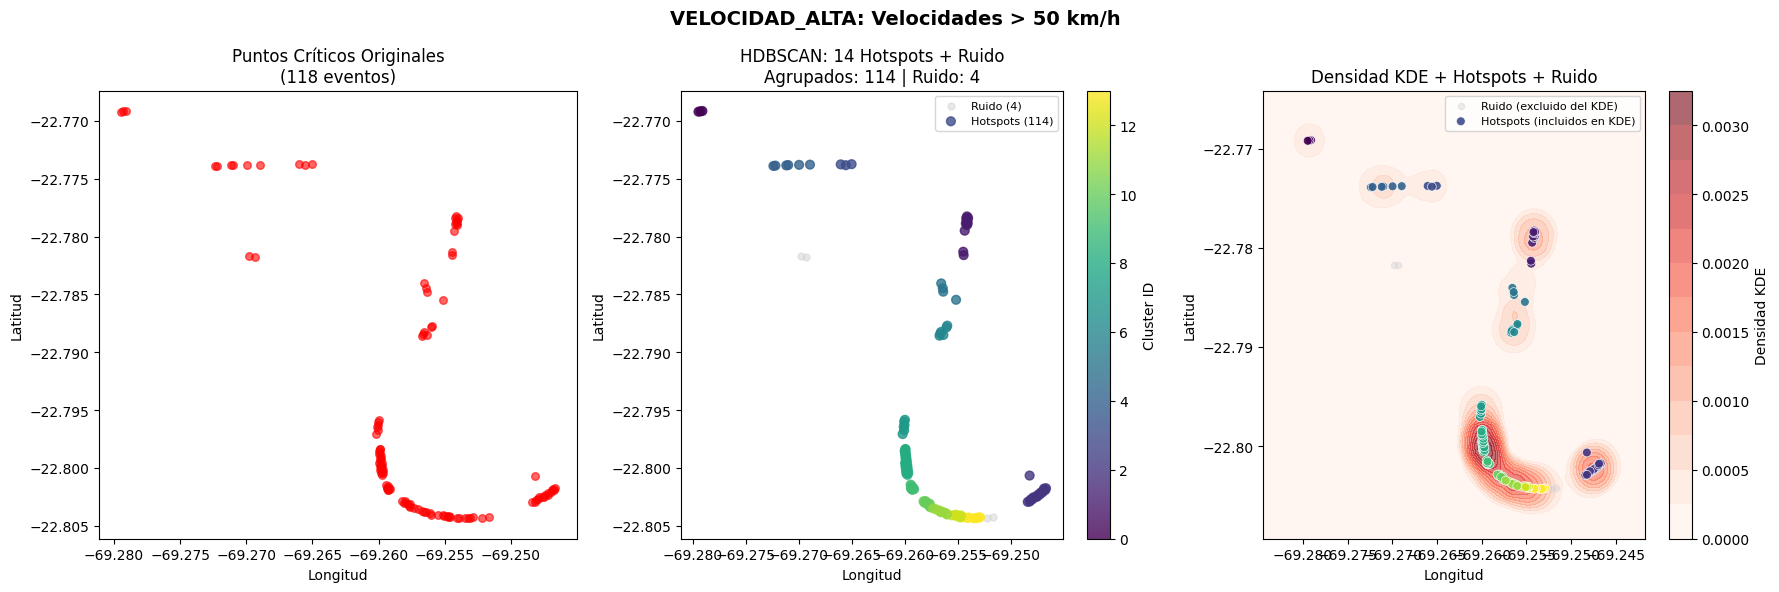


=================📊 ESTADÍSTICAS DETALLADAS==================
📍 Total puntos críticos: 118
✅ Puntos en hotspots: 114 (96.6%)
🔀 Puntos de ruido: 4 (3.4%)
🎯 Hotspots identificados: 14

💡 INTERPRETACIÓN: 🎯 EXCELENTE concentración geográfica
💡 RECOMENDACIÓN: Intervenciones puntuales muy efectivas


In [91]:
rule_name="velocidad_alta"
coords_data=critical_coords["velocidad_alta"]
result = analyze_coordinates_hdbscan_kde(rule_name, coords_data)

### Segunda regla (Ac lat 0.15 +- (avg_lateral_a))

In [43]:
rule_name="aceleracion_lateral"
coords_data=critical_coords["aceleracion_lateral"]
result = analyze_coordinates_hdbscan_kde(rule_name, coords_data)


========================🎯 ACELERACION_LATERAL=========================
📝 Aceleración lateral > ±0.15g
📍 Coordenadas: 1 puntos
⚠️ Muy pocos puntos para análisis (mínimo 5)


### Tercera regla (Ac lon 0.1+- (avg_longitudinal_a))

In [44]:
rule_name="aceleracion_longitudinal"
coords_data=critical_coords["aceleracion_longitudinal"]
result = analyze_coordinates_hdbscan_kde(rule_name, coords_data)


======================🎯 ACELERACION_LONGITUDINAL======================
📝 Aceleración longitudinal > ±0.1g
📍 Coordenadas: 5 puntos
⚙️ HDBSCAN: min_cluster_size=3, min_samples=2
📊 Resultados:
   🎯 Hotspots: 0
   ✅ Puntos agrupados: 0
   🔀 Puntos dispersos: 5
   📈 Agrupamiento: 0.0%
   → No hay concentraciones geográficas claras


### Cuarta regla (Vver 3+- (avg_vertical_speed))


=========================🎯 VELOCIDAD_VERTICAL=========================
📝 Velocidad vertical > ±3 m/s
📍 Coordenadas: 129 puntos
⚙️ HDBSCAN: min_cluster_size=4, min_samples=2
📊 Resultados:
   🎯 Hotspots: 14
   ✅ Puntos agrupados: 120
   🔀 Puntos dispersos: 9
   📈 Agrupamiento: 93.0%

📍 HOTSPOTS IDENTIFICADOS:
   Hotspot 1:
     📍 (-22.768603, -69.282626)
     📊 6 eventos
     ✅ Confianza: 0.836
     📏 Radio: 0.32 km
   Hotspot 2:
     📍 (-22.766075, -69.252553)
     📊 6 eventos
     ✅ Confianza: 0.700
     📏 Radio: 0.12 km
   Hotspot 3:
     📍 (-22.771459, -69.252646)
     📊 16 eventos
     ✅ Confianza: 0.924
     📏 Radio: 0.07 km
   Hotspot 4:
     📍 (-22.789765, -69.254191)
     📊 4 eventos
     ✅ Confianza: 1.000
     📏 Radio: 0.05 km
   Hotspot 5:
     📍 (-22.800365, -69.232668)
     📊 8 eventos
     ✅ Confianza: 0.882
     📏 Radio: 0.09 km
   Hotspot 6:
     📍 (-22.800459, -69.242762)
     📊 8 eventos
     ✅ Confianza: 1.000
     📏 Radio: 0.04 km
   Hotspot 7:
     📍 (-22.801051, -

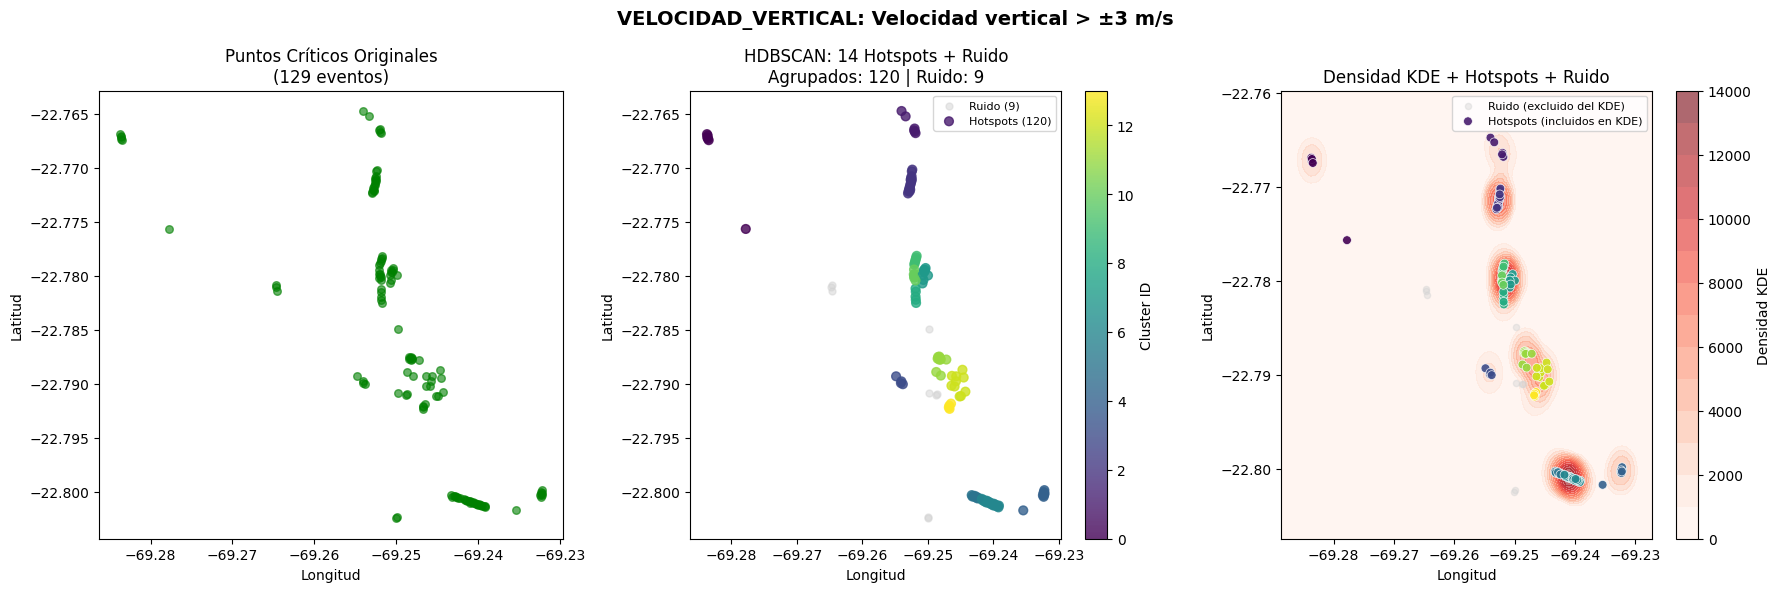


=================📊 ESTADÍSTICAS DETALLADAS==================
📍 Total puntos críticos: 129
✅ Puntos en hotspots: 120 (93.0%)
🔀 Puntos de ruido: 9 (7.0%)
🎯 Hotspots identificados: 14

💡 INTERPRETACIÓN: 🎯 EXCELENTE concentración geográfica
💡 RECOMENDACIÓN: Intervenciones puntuales muy efectivas


In [45]:
rule_name="velocidad_vertical"
coords_data=critical_coords["velocidad_vertical"]
result = analyze_coordinates_hdbscan_kde(rule_name, coords_data)

### Quinta regla (Sver*speed (Ondulaciones rápidas))

In [48]:
rule_name="ondulaciones_rapidas"
coords_data=critical_coords["ondulaciones_rapidas"]
result = analyze_coordinates_hdbscan_kde(rule_name, coords_data)


========================🎯 ONDULACIONES_RAPIDAS========================
📝 Ondulaciones rápidas (Sver×Speed)
📍 Coordenadas: 0 puntos
⚠️ Muy pocos puntos para análisis (mínimo 5)


### Sexta regla (avg_speed(>50) * avg_ratius_ot(<50))

In [49]:
rule_name="curvas_rapidas"
coords_data=critical_coords["curvas_rapidas"]
result = analyze_coordinates_hdbscan_kde(rule_name, coords_data)


===========================🎯 CURVAS_RAPIDAS===========================
📝 Curvas rápidas (Speed>50 & Radio<50)
📍 Coordenadas: 0 puntos
⚠️ Muy pocos puntos para análisis (mínimo 5)


### FUNCION return df todas las reglas con sus clusters

In [5]:
# Rango de radios (m) → Velocidad máxima (kph)
radius_speed_ranges = [
    (0, 15, 8),
    (15, 20, 9),
    (20, 25, 10),
    (25, 32, 11),
    (32, 37, 12),
    (37, 42, 13),
    (42, 49, 14),
    (49, 53, 15),
    (53, 58, 16),
    (58, 63, 17),
    (63, 68, 18),
    (68, 73, 19),
    (73, 79, 20),
    (79, 84, 21),
    (84, 90, 22),
    (90, 96, 23),
    (96, 106, 24),
    (106, 113, 25),
    (113, 120, 26),
    (120, 132, 27),
    (132, 141, 28),
    (141, 150, 29),
    (150, 160, 30),
    (160, 170, 31),
    (170, 198, 32)
]

def get_max_speed_from_radius(radius):
    for r_min, r_max, vmax in radius_speed_ranges:
        if r_min <= radius <= r_max:
            return vmax
    return np.inf  # si está fuera de los rangos, no marcar como crítico


In [7]:
def add_clustering_columns_to_dataframe(df):
    """
    Toma el DataFrame original y agrega columnas con resultados de clustering y KDE
    
    Parámetros:
    df: DataFrame original con todas las filas
    
    Retorna:
    df: Mismo DataFrame pero con columnas nuevas:
        - cluster_r1, kde_r1 (velocidad alta)
        - cluster_r2, kde_r2 (aceleración lateral) 
        - cluster_r3, kde_r3 (aceleración longitudinal)
        - cluster_r4, kde_r4 (velocidad vertical)
        - cluster_r5, kde_r5 (ondulaciones rápidas)
        - cluster_r6, kde_r6 (curvas rápidas)
    """
    
    print("🚀 AGREGANDO COLUMNAS DE CLUSTERING AL DATAFRAME ORIGINAL")
    print("=" * 60)
    
    # Crear copia del DataFrame para no modificar el original
    df_result = df.copy()
    
    # Verificar columnas necesarias
    required_columns = ['centroid_lat', 'centroid_lng', 'avg_speed', 'avg_lateral_a', 
                       'avg_longitudinal_a', 'avg_vertical_speed']
    
    missing_columns = [col for col in required_columns if col not in df.columns]
    if missing_columns:
        print(f"❌ ERROR: Columnas faltantes: {missing_columns}")
        return df_result
    
    # Definir las reglas
    rules_definitions = {
        'r1': {
            'name': 'velocidad_alta',
            'description': 'Velocidades > 50 km/h',
            'condition': lambda df: df['avg_speed'] > 50
        },
        'r2': {
            'name': 'aceleracion_lateral', 
            'description': 'Aceleración lateral > ±0.15g',
            'condition': lambda df: np.abs(df['avg_lateral_a']) > 0.15
        },
        'r3': {
            'name': 'aceleracion_longitudinal',
            'description': 'Aceleración longitudinal > ±0.1g', 
            'condition': lambda df: np.abs(df['avg_longitudinal_a']) > 0.1
        },
        'r4': {
            'name': 'velocidad_vertical',
            'description': 'Velocidad vertical > ±3 m/s',
            'condition': lambda df: np.abs(df['avg_vertical_speed']) > 3
        }
    }
    
    # Regla 5: Ondulaciones rápidas 
    if 'avg_vertical_speed' in df.columns:
        ondulacion_score = (df['avg_speed'] > 50) & (df['avg_vertical_speed'] > 3)
        threshold_ondulacion = (df['avg_speed'] > 50) & (df['avg_vertical_speed'] > 3)
        rules_definitions['r5'] = {
            'name': 'ondulaciones_rapidas',
            'description': f'Ondulaciones rápidas (Sver×Speed) avg_speed>50 & avg_vertical_speed',
            'condition': lambda df: (df['avg_speed'] > 50) & (df['avg_vertical_speed'] > 3)
        }
    
    # Regla 6: Curvas rápidas (si existe columna avg_radius_ot)
    if 'avg_ratius_ot' in df.columns:
        rules_definitions['r6'] = {
            'name': 'curvas_rapidas',
            'description': 'Curvas rápidas (velocidad excede la máxima permitida para el radio)',
            'condition': lambda df: df.apply(
                lambda row: row['avg_speed'] > get_max_speed_from_radius(row['avg_ratius_ot']),
                axis=1
            )
        }

    all_coords = df_result[['centroid_lat', 'centroid_lng']].dropna()
    all_indices = all_coords.index
    all_coords_array = all_coords.values        
    
    # Procesar cada regla
    for rule_id, rule_info in rules_definitions.items():
        
        print(f"\n🎯 Procesando {rule_id.upper()}: {rule_info['description']}")
        
        try:
            # Aplicar condición para identificar eventos críticos
            critical_mask = rule_info['condition'](df_result)
            critical_indices = df_result[critical_mask].index
            
            print(f"   📍 Eventos críticos encontrados: {len(critical_indices)}")
            
            # Inicializar columnas con -999 (no aplica) y NaN para KDE
            cluster_col = f'cluster_{rule_info["name"]}'
            kde_col = f'kde_{rule_info["name"]}'
            
            df_result[cluster_col] = -999  # -999 = no es evento crítico para esta regla
            df_result[kde_col] = 0.0    # NaN = no tiene densidad KDE
            
            if len(critical_indices) < 5:
                print(f"   ⚠️ Muy pocos eventos críticos para clustering (mínimo 5)")
                # Las columnas quedan con valores por defecto
                continue
            
            # Extraer coordenadas de eventos críticos
            critical_coords = df_result.loc[critical_indices, ['centroid_lat', 'centroid_lng']].dropna()
            valid_indices = critical_coords.index
            coords_array = critical_coords.values
            
            if len(coords_array) < 5:
                print(f"   ⚠️ Muy pocos eventos con coordenadas válidas")
                continue
            
            # Aplicar HDBSCAN
            n_points = len(coords_array)
            min_cluster_size = max(3, n_points // 30)
            min_samples = max(2, min_cluster_size // 2)
            
            hdbscan = HDBSCAN(
                min_cluster_size=min_cluster_size,
                min_samples=min_samples,
                cluster_selection_epsilon=0.0005,
                metric='euclidean'
            )
            
            clusters = hdbscan.fit_predict(coords_array)
            
            # Asignar resultados de clustering
            df_result.loc[valid_indices, cluster_col] = clusters
            
            # Estadísticas de clustering
            n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
            n_noise = list(clusters).count(-1)
            n_in_clusters = len(clusters) - n_noise
            
            print(f"   🎯 Hotspots identificados: {n_clusters}")
            print(f"   ✅ Eventos en hotspots: {n_in_clusters}")
            print(f"   🔀 Eventos de ruido: {n_noise}")
            
            # Aplicar KDE si hay suficientes puntos en clusters
            if n_clusters > 0 and n_in_clusters >= 5:
                
                # KDE solo en puntos que están en clusters (no ruido)
                cluster_mask = clusters != -1
                clustered_coords = coords_array[cluster_mask]
                clustered_indices = valid_indices[cluster_mask]
                
                try:
                    kde = KernelDensity(bandwidth=0.003, kernel='epanechnikov')
                    kde.fit(clustered_coords)
                    
                    # Calcular densidad KDE para todos los eventos críticos
                    kde_scores = kde.score_samples(all_coords_array)
                    kde_density = np.exp(kde_scores)
                    probs = kde_density / kde_density.sum()
                    
                    # Asignar densidades KDE
                    df_result.loc[all_indices, kde_col] = probs
                    
                    print(f"   📊 KDE calculado para {len(valid_indices)} puntos")
                    print(f"   📈 Densidad máxima: {kde_density.max():.6f}")
                    
                except Exception as kde_error:
                    print(f"   ⚠️ Error en KDE: {kde_error}")
            
            else:
                print(f"   ⚠️ No se puede calcular KDE (pocos clusters o puntos)")
        
        except Exception as rule_error:
            print(f"   ❌ Error procesando regla {rule_id}: {rule_error}")
            continue
    
    # Mostrar resumen final
    print(f"\n{'📊 RESUMEN FINAL':=^60}")
    
    cluster_columns = [col for col in df_result.columns if col.startswith('cluster_')]
    kde_columns = [col for col in df_result.columns if col.startswith('kde_')]
    
    print(f"✅ Columnas de clustering agregadas: {len(cluster_columns)}")
    for col in cluster_columns:
        n_clusters = len(df_result[df_result[col] >= 0][col].unique())
        n_in_clusters = len(df_result[df_result[col] >= 0])
        n_noise = len(df_result[df_result[col] == -1])
        print(f"   {col}: {n_clusters} hotspots, {n_in_clusters} eventos agrupados, {n_noise} ruido")
    
    print(f"✅ Columnas de KDE agregadas: {len(kde_columns)}")
    for col in kde_columns:
        n_with_kde = len(df_result[df_result[col].notna()])
        print(f"   {col}: {n_with_kde} eventos con densidad KDE")
    
    print(f"\n📏 DataFrame final: {len(df_result)} filas × {len(df_result.columns)} columnas")
    print(f"📏 Nuevas columnas agregadas: {len(cluster_columns + kde_columns)}")
    
    return df_result

def get_clustering_summary(df_with_clusters):
    """
    Función auxiliar para obtener resumen de los resultados de clustering
    """
    
    print("📊 RESUMEN DETALLADO DE CLUSTERING")
    print("=" * 50)
    
    cluster_columns = [col for col in df_with_clusters.columns if col.startswith('cluster_')]
    kde_columns = [col for col in df_with_clusters.columns if col.startswith('kde_')]
    
    summary_data = []
    
    for col in cluster_columns:
        rule_id = col.split('_')[1]  # Extraer r1, r2, etc.
        
        # Estadísticas de clustering
        all_clusters = df_with_clusters[col]
        critical_events = all_clusters[all_clusters != -999]  # Eventos que aplican a esta regla
        
        if len(critical_events) == 0:
            continue
            
        n_total_critical = len(critical_events)
        n_in_clusters = len(critical_events[critical_events >= 0])
        n_noise = len(critical_events[critical_events == -1])
        n_unique_clusters = len(critical_events[critical_events >= 0].unique())
        
        clustering_rate = (n_in_clusters / n_total_critical * 100) if n_total_critical > 0 else 0
        
        # Estadísticas de KDE
        kde_col = f'kde_{rule_id}'
        n_with_kde = 0
        max_kde = 0
        if kde_col in df_with_clusters.columns:
            kde_values = df_with_clusters[kde_col].dropna()
            n_with_kde = len(kde_values)
            max_kde = kde_values.max() if len(kde_values) > 0 else 0
        
        summary_data.append({
            'Regla': rule_id.upper(),
            'Eventos_Críticos': n_total_critical,
            'Hotspots': n_unique_clusters,
            'En_Clusters': n_in_clusters,
            'Ruido': n_noise,
            'Tasa_Agrupamiento_%': f"{clustering_rate:.1f}%",
            'Con_KDE': n_with_kde,
            'Max_Densidad_KDE': f"{max_kde:.6f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    return summary_df

def export_hotspots_coordinates(df_with_clusters, output_file='hotspots_coordinates.csv'):
    """
    Exporta las coordenadas de los centroides de cada hotspot
    """
    
    cluster_columns = [col for col in df_with_clusters.columns if col.startswith('cluster_')]
    
    hotspots_list = []
    
    for col in cluster_columns:
        rule_id = col.split('_')[1]
        
        # Obtener datos de esta regla
        rule_data = df_with_clusters[df_with_clusters[col] >= 0]  # Solo clusters válidos
        
        if len(rule_data) == 0:
            continue
        
        # Calcular centroide de cada cluster
        for cluster_id in rule_data[col].unique():
            cluster_points = rule_data[rule_data[col] == cluster_id]
    
            if len(cluster_points) > 0:
                centroid_lat = cluster_points['centroid_lat'].mean()
                centroid_lon = cluster_points['centroid_lng'].mean()
                n_events = len(cluster_points)
                
                # KDE promedio si existe
                kde_col = f'kde_{rule_id}'
                avg_kde = 0
                if kde_col in cluster_points.columns:
                    kde_values = cluster_points[kde_col].dropna()
                    avg_kde = kde_values.mean() if len(kde_values) > 0 else 0
                
                hotspots_list.append({
                    'regla': rule_id,
                    'cluster_id': cluster_id,
                    'centroid_lat': centroid_lat,
                    'centroid_lon': centroid_lon,
                    'n_events': n_events,
                    'avg_kde_density': avg_kde
                })
    
    hotspots_df = pd.DataFrame(hotspots_list)
    hotspots_df.to_csv(output_file, index=False)
    
    print(f"📁 Coordenadas de hotspots exportadas a: {output_file}")
    print(f"📊 Total hotspots exportados: {len(hotspots_df)}")
    
    return hotspots_df

# ===============================
# FUNCIÓN PRINCIPAL PARA USAR
# ===============================

def process_dataframe_with_clustering(df, export_coordinates=True):
    """
    Función principal que procesa todo el DataFrame
    
    Parámetros:
    df: DataFrame original
    export_coordinates: Si exportar coordenadas de hotspots
    
    Retorna:
    dict con:
    - 'dataframe': DataFrame con columnas nuevas
    - 'summary': Resumen de clustering
    - 'hotspots': Coordenadas de hotspots (si export_coordinates=True)
    """
    
    print("🚀 PROCESAMIENTO COMPLETO DEL DATAFRAME")
    print("=" * 60)
    
    # Agregar columnas de clustering
    df_with_clusters = add_clustering_columns_to_dataframe(df)
    
    # Generar resumen
    summary = get_clustering_summary(df_with_clusters)
    
    # Exportar coordenadas si se solicita
    hotspots_coords = None
    if export_coordinates:
        hotspots_coords = export_hotspots_coordinates(df_with_clusters)
    
    return {
        'dataframe': df_with_clusters,
        'summary': summary, 
        'hotspots': hotspots_coords
    }

# ===============================
# EJEMPLO DE USO:
# ===============================

# # Procesar DataFrame original
result = process_dataframe_with_clustering(df_original)
# 
# # Obtener DataFrame con nuevas columnas
df_final = result['dataframe']
# 
# # Ver las nuevas columnas
new_columns = [col for col in df_final.columns if col.startswith(('cluster_', 'kde_'))]
print("Nuevas columnas:", new_columns)
# 
# # Ver ejemplos de eventos en hotspots
#velocity_hotspots = df_final[df_final['cluster_r6'] >= 0]
#print(f"Eventos de velocidad alta en hotspots: {len(velocity_hotspots)}")

🚀 PROCESAMIENTO COMPLETO DEL DATAFRAME
🚀 AGREGANDO COLUMNAS DE CLUSTERING AL DATAFRAME ORIGINAL

🎯 Procesando R1: Velocidades > 50 km/h
   📍 Eventos críticos encontrados: 0
   ⚠️ Muy pocos eventos críticos para clustering (mínimo 5)

🎯 Procesando R2: Aceleración lateral > ±0.15g
   📍 Eventos críticos encontrados: 38
   🎯 Hotspots identificados: 7
   ✅ Eventos en hotspots: 34
   🔀 Eventos de ruido: 4
   📊 KDE calculado para 38 puntos
   📈 Densidad máxima: 13220.741246

🎯 Procesando R3: Aceleración longitudinal > ±0.1g
   📍 Eventos críticos encontrados: 18
   🎯 Hotspots identificados: 3
   ✅ Eventos en hotspots: 16
   🔀 Eventos de ruido: 2
   📊 KDE calculado para 18 puntos
   📈 Densidad máxima: 9147.223874

🎯 Procesando R4: Velocidad vertical > ±3 m/s
   📍 Eventos críticos encontrados: 26
   🎯 Hotspots identificados: 5
   ✅ Eventos en hotspots: 23
   🔀 Eventos de ruido: 3
   📊 KDE calculado para 26 puntos
   📈 Densidad máxima: 15137.861323

🎯 Procesando R5: Ondulaciones rápidas (Sver×Spe

In [8]:
df_final

,refe,h3_cell,loading_status,n_points,centroid_lat,centroid_lng,avg_heading,avg_speed,avg_vertical_speed,avg_height,...,cluster_velocidad_alta,kde_velocidad_alta,cluster_aceleracion_lateral,kde_aceleracion_lateral,cluster_aceleracion_longitudinal,kde_aceleracion_longitudinal,cluster_velocidad_vertical,kde_velocidad_vertical,cluster_ondulaciones_rapidas,kde_ondulaciones_rapidas
0,341139VBOX,8c66034b04da1ff,Loaded,6,7.906381,-75.536625,183.52,21.30,0.00,122.32,...,-999,0.0,-999,0.0,-999,0.000568,-999,0.0,-999,0.0
1,341139VBOX,8c66034b04da3ff,Loaded,5,7.906241,-75.536523,180.46,20.86,-0.32,121.84,...,-999,0.0,-999,0.0,-999,0.000558,-999,0.0,-999,0.0
2,341139VBOX,8c66034b04da9ff,Loaded,6,7.906529,-75.536553,185.23,21.92,0.23,122.18,...,-999,0.0,-999,0.0,-999,0.000565,-999,0.0,-999,0.0
3,341139VBOX,8c66034b04de1ff,Loaded,5,7.906818,-75.536584,137.55,19.87,0.13,122.14,...,-999,0.0,-999,0.0,-999,0.000560,-999,0.0,-999,0.0
4,341139VBOX,8c66034b04de3ff,Loaded,2,7.906678,-75.536481,170.50,21.48,0.11,123.24,...,-999,0.0,-1,0.0,-999,0.000558,-999,0.0,-999,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,341139VBOX,8c661c94dd965ff,Empty,3,7.925121,-75.575462,333.18,29.28,0.23,95.64,...,-999,0.0,-999,0.0,-999,0.000000,-999,0.0,-999,0.0
3340,341139VBOX,8c661c94dd967ff,Empty,2,7.924981,-75.575360,242.80,31.95,-0.06,95.73,...,-999,0.0,-999,0.0,-999,0.000000,-999,0.0,-999,0.0
3341,341139VBOX,8c661c94dd9a5ff,Empty,2,7.923705,-75.574788,326.90,30.30,1.33,89.14,...,-999,0.0,-999,0.0,-999,0.000178,-999,0.0,-999,0.0
3342,341139VBOX,8c661c94dd9a7ff,Empty,3,7.923565,-75.574686,315.60,31.95,1.34,88.21,...,-999,0.0,-999,0.0,-999,0.000219,-999,0.0,-999,0.0


In [105]:
velocity_hotspots[df_final['cluster_r1'] == 9]["kde_r1"].sum()

C:\Users\sbuitrago\AppData\Local\Temp\ipykernel_18568\2802591246.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  velocity_hotspots[df_final['cluster_r1'] == 9]["kde_r1"].sum()


np.float64(0.3399470881489586)